<a href="https://colab.research.google.com/github/KT2001/BPARMS_Face_recognition/blob/main/FaceRecognitionFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Installing the dependencies**

In [ ]:
!unzip /content/drive/MyDrive/10_faces_dataset.zip

In [2]:
!pip install mtcnn
!pip install streamlit
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 76.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.0 MB/s eta 0:00:00
  Created wheel for validators: filename

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model, load_model
from keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from tensorflow import keras

# visulizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
from numpy import asarray
from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import random
import time
import cv2
import glob
from scipy import misc
import pathlib
from imageio import imread
import streamlit as st
from mtcnn.mtcnn import MTCNN
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

### Model Building

For this project, the model is based on the FaceNet model by Hiroki Taniai. It was trained on MS-Celeb-1M dataset and expects input images to be color, to have their pixel values whitened (standardized across all three channels), and to have a square shape of 160×160 pixels.

In [4]:
# Inception_resnet_v1.py
from functools import partial
from keras.models import Model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.layers import add
from keras import backend as K


def scaling(x, scale):
    return x * scale


def conv2d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):
    x = Conv2D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               use_bias=use_bias,
               name=name)(x)
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        bn_name = _generate_layer_name('BatchNorm', prefix=name)
        x = BatchNormalization(axis=bn_axis, momentum=0.995, epsilon=0.001,
                               scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = _generate_layer_name('Activation', prefix=name)
        x = Activation(activation, name=ac_name)(x)
    return x


def _generate_layer_name(name, branch_idx=None, prefix=None):
    if prefix is None:
        return None
    if branch_idx is None:
        return '_'.join((prefix, name))
    return '_'.join((prefix, 'Branch', str(branch_idx), name))


def _inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    if block_idx is None:
        prefix = None
    else:
        prefix = '_'.join((block_type, str(block_idx)))
    name_fmt = partial(_generate_layer_name, prefix=prefix)

    if block_type == 'Block35':
        branch_0 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 32, 3, name=name_fmt('Conv2d_0b_3x3', 1))
        branch_2 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0b_3x3', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0c_3x3', 2))
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'Block17':
        branch_0 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 128, [1, 7], name=name_fmt('Conv2d_0b_1x7', 1))
        branch_1 = conv2d_bn(branch_1, 128, [7, 1], name=name_fmt('Conv2d_0c_7x1', 1))
        branches = [branch_0, branch_1]
    elif block_type == 'Block8':
        branch_0 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 192, [1, 3], name=name_fmt('Conv2d_0b_1x3', 1))
        branch_1 = conv2d_bn(branch_1, 192, [3, 1], name=name_fmt('Conv2d_0c_3x1', 1))
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "Block35", "Block17" or "Block8", '
                         'but got: ' + str(block_type))

    mixed = Concatenate(axis=channel_axis, name=name_fmt('Concatenate'))(branches)
    up = conv2d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   use_bias=True,
                   name=name_fmt('Conv2d_1x1'))
    up = Lambda(scaling,
                output_shape=K.int_shape(up)[1:],
                arguments={'scale': scale})(up)
    x = add([x, up])
    if activation is not None:
        x = Activation(activation, name=name_fmt('Activation'))(x)
    return x


def InceptionResNetV1(input_shape=(160, 160, 3),
                      classes=128,
                      dropout_keep_prob=0.8,
                      weights_path=None):
    inputs = Input(shape=input_shape)
    x = conv2d_bn(inputs, 32, 3, strides=2, padding='valid', name='Conv2d_1a_3x3')
    x = conv2d_bn(x, 32, 3, padding='valid', name='Conv2d_2a_3x3')
    x = conv2d_bn(x, 64, 3, name='Conv2d_2b_3x3')
    x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
    x = conv2d_bn(x, 80, 1, padding='valid', name='Conv2d_3b_1x1')
    x = conv2d_bn(x, 192, 3, padding='valid', name='Conv2d_4a_3x3')
    x = conv2d_bn(x, 256, 3, strides=2, padding='valid', name='Conv2d_4b_3x3')

    # 5x Block35 (Inception-ResNet-A block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.17,
                                    block_type='Block35',
                                    block_idx=block_idx)

    # Mixed 6a (Reduction-A block):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    name_fmt = partial(_generate_layer_name, prefix='Mixed_6a')
    branch_0 = conv2d_bn(x,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1, 192, 3, name=name_fmt('Conv2d_0b_3x3', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 2))(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_6a')(branches)

    # 10x Block17 (Inception-ResNet-B block):
    for block_idx in range(1, 11):
        x = _inception_resnet_block(x,
                                    scale=0.1,
                                    block_type='Block17',
                                    block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    name_fmt = partial(_generate_layer_name, prefix='Mixed_7a')
    branch_0 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 0))
    branch_0 = conv2d_bn(branch_0,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_2 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 2))
    branch_2 = conv2d_bn(branch_2, 256, 3, name=name_fmt('Conv2d_0b_3x3', 2))
    branch_2 = conv2d_bn(branch_2,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 2))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 3))(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_7a')(branches)

    # 5x Block8 (Inception-ResNet-C block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.2,
                                    block_type='Block8',
                                    block_idx=block_idx)
    x = _inception_resnet_block(x,
                                scale=1.,
                                activation=None,
                                block_type='Block8',
                                block_idx=6)

    # Classification block
    x = GlobalAveragePooling2D(name='AvgPool')(x)
    x = Dropout(1.0 - dropout_keep_prob, name='Dropout')(x)
    # Bottleneck
    x = Dense(classes, use_bias=False, name='Bottleneck')(x)
    bn_name = _generate_layer_name('BatchNorm', prefix='Bottleneck')
    x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False,
                           name=bn_name)(x)

    # Create model
    model = Model(inputs, x, name='inception_resnet_v1')
    if weights_path is not None:
        model.load_weights(weights_path)

    return model

In [5]:
FACENET = InceptionResNetV1(weights_path='/content/drive/MyDrive/facenet_keras_weights.h5')

In [6]:
FACENET.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [7]:
FACENET.save('facenet.h5') # We will save the Facenet model so that it could be used in app.py file

2023-01-25 01:40:02.309 WARNING tensorflow: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [8]:
facenet = keras.models.load_model('facenet.h5') # loading the model

2023-01-25 01:40:08.552 WARNING tensorflow: No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [9]:
facenet.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [10]:
facenet.load_weights('/content/drive/MyDrive/facenet_keras_weights.h5')

# MTCNN

MTCNN (Multi-task Cascaded Convolutional Networks) is a deep learning-based method for face detection, alignment, and feature extraction. It uses a cascaded architecture with three sub-networks, each responsible for a different task: face detection, facial landmark localization, and face alignment. The MTCNN algorithm is known for its high accuracy and fast processing speed. It has been widely used in various applications such as facial recognition and facial expression analysis. 

1/1 [==============================] - 0s 158ms/step


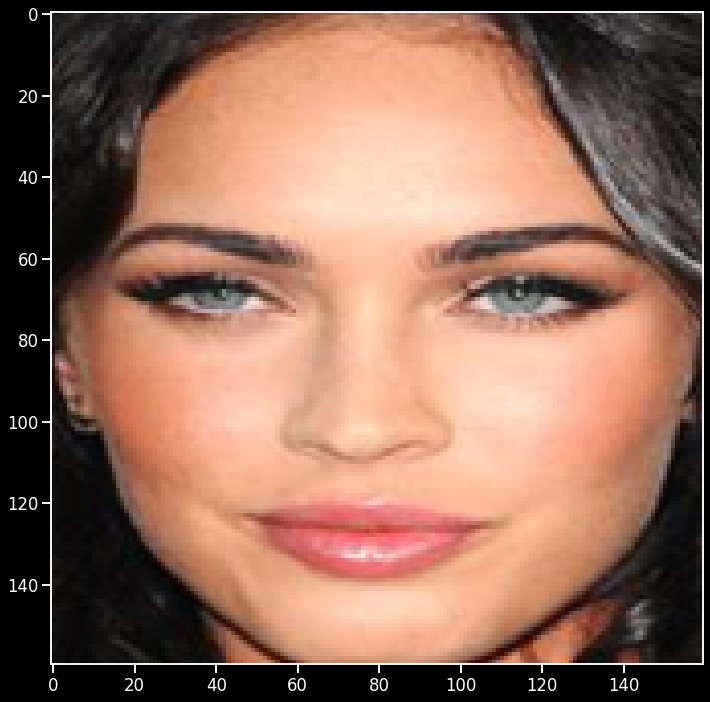

(160, 160, 3)


In [14]:
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load the photo and extract the face
pixels = extract_face('/content/10_faces_dataset/train/Megan_Fox/065_016dc8e2.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [15]:
train = '/content/10_faces_dataset/train'
test = '/content/10_faces_dataset/test'

In [16]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + '/' + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [17]:
# load train dataset
trainX, trainy = load_dataset(train)
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset(test)
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('10-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

1/1 [==============================] - 0s 134ms/step
loaded 40 sample for class: Robert_Downey_jr
1/1 [==============================] - 0s 125ms/step
loaded 40 sample for class: Brad_Pitt
1/1 [==============================] - 0s 124ms/step
loaded 17 sample for class: elton_john
1/1 [==============================] - 0s 129ms/step
loaded 19 sample for class: madonna
1/1 [==============================] - 0s 154ms/step
loaded 40 sample for class: Tom_Cruise
1/1 [==============================] - 0s 186ms/step
loaded 21 sample for class: jerry_seinfeld
1/1 [==============================] - 0s 149ms/step
loaded 22 sample for class: mindy_kaling
1/1 [==============================] - 0s 129ms/step
loaded 40 sample for class: Leonardo_DiCaprio
1/1 [==============================] - 0s 145ms/step
loaded 40 sample for class: Megan_Fox
1/1 [==============================] - 0s 133ms/step
loaded 14 sample for class: ben_afflek
(293, 160, 160, 3) (293,)
1/1 [==============================] - 0

In [19]:
# load the face dataset
data = np.load('10-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (293, 160, 160, 3) (293,) (50, 160, 160, 3) (50,)


# Getting the embeddings

In [20]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('10-celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 90ms/step
(293, 128)
1/1 [==============================] - 0s 91ms/step
(50, 128)


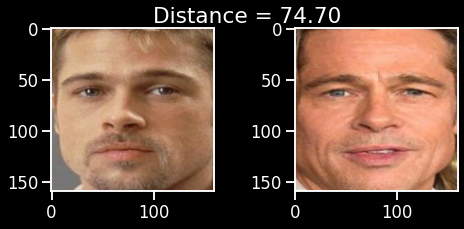

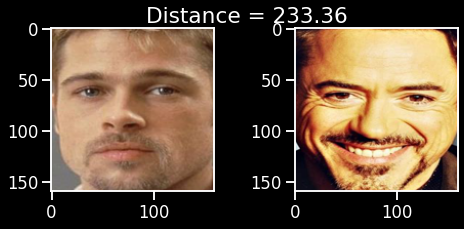

In [28]:
# Show distance between pairs
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(emdTrainX[idx1], emdTrainX[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(trainX[idx1])
    plt.subplot(122)
    plt.imshow(trainX[idx2]);    

show_pair(77, 78)
show_pair(77, 20)

# Training the SVM model

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=293, test=50
Accuracy: train=100.000, test=100.000


Predicted: 
['Brad_Pitt' 'Leonardo_DiCaprio' 'Megan_Fox' 'Robert_Downey_jr'
 'Tom_Cruise'] 
[ 0.95544638  1.14610286  1.47696235  5.18351369  1.35534175  1.74737059
  2.32882879  0.81791308  1.73525487 83.25326564]
Expected: mindy_kaling


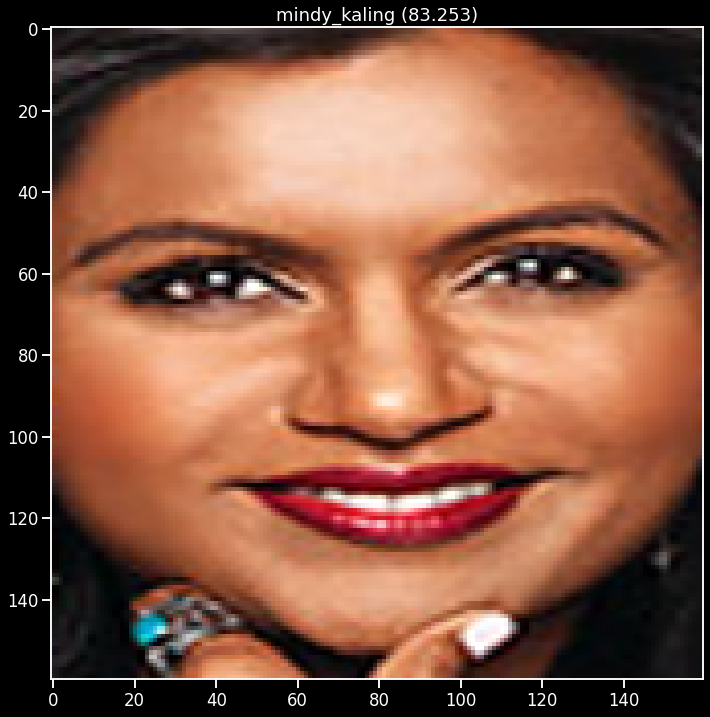

In [22]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

In [23]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [24]:
with open('model.pkl', 'rb') as f:
    Model = pickle.load(f)

Predicted: 
['Brad_Pitt' 'Leonardo_DiCaprio' 'Megan_Fox' 'Robert_Downey_jr'
 'Tom_Cruise'] 
[ 8.33287144  1.74256642  2.79676881 55.51625245  2.79020729  5.78674209
  6.31253503 10.82372919  2.37201205  3.52631523]
Expected: Robert_Downey_jr


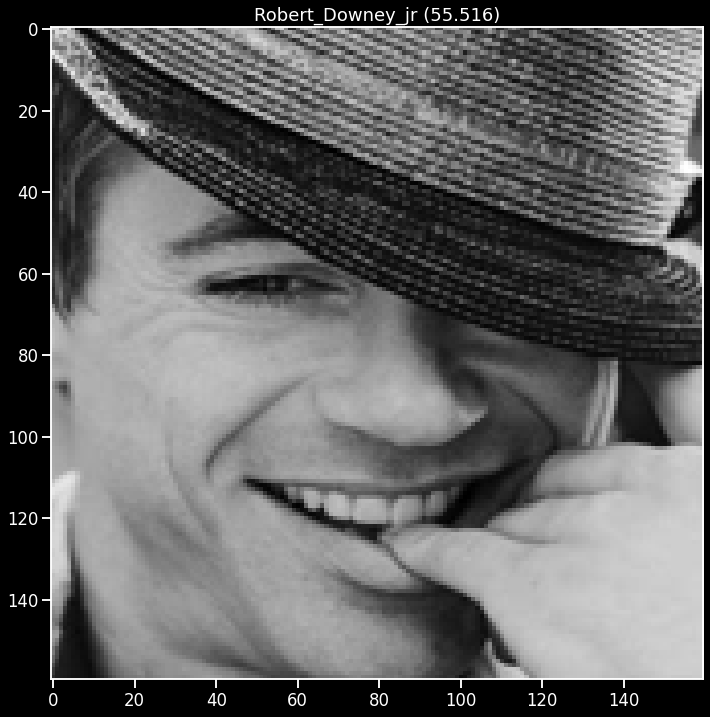

In [26]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = Model.predict(samples)
yhat_prob = Model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

To embed the dataset into 2D space for displaying identity clusters, t-distributed Stochastic Neighbor Embedding (t-SNE) is applied to the 128-dimensional embedding vectors. Except from a few outliers, identity clusters are well separated.

### Data Visulization

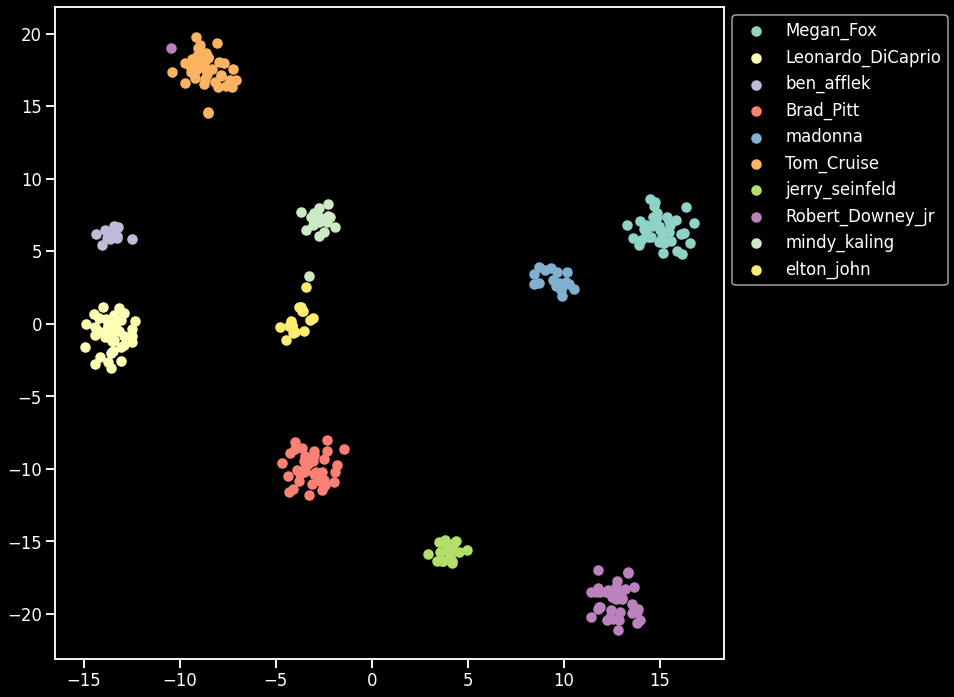

In [33]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(emdTrainX)

for i, t in enumerate(set(trainy)):
    idx = trainy == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

### Creating The App

In [47]:
%%writefile app.py
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model, load_model
from keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from tensorflow import keras

# visulizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
from numpy import asarray
from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import random
import time
import cv2
import glob
from scipy import misc
import pathlib
from imageio import imread
import streamlit as st
from mtcnn.mtcnn import MTCNN
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

def main():
  facenet = keras.models.load_model('/content/facenet.h5')
  facenet.load_weights('/content/drive/MyDrive/facenet_keras_weights.h5')
  st.title("Face recognition")
  # load the face dataset
  data = np.load('/content/10-celebrity-faces-embeddings.npz')
  trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
  in_encoder = Normalizer()
  emdTrainX_norm = in_encoder.transform(trainX)
  emdTestX_norm = in_encoder.transform(testX)
  outencoder = LabelEncoder()
  outencoder.fit(trainy)
  trainy_enc = outencoder.transform(trainy)
  testy_enc = outencoder.transform(testy)
  # fit model
  classifier = SVC(kernel='linear', probability=True)
  classifier.fit(emdTrainX_norm, trainy_enc)

  uploaded_file = st.file_uploader("Choose an image", type=["jpg", "png", "jpeg"])
  if uploaded_file is not None:
      # Use MTCNN to detect and align faces in the image
      # extract a single face from a given photograph
      def extract_face(filename, required_size=(160, 160)):
          # load image from file
          image = Image.open(filename)
          # convert to RGB, if needed
          image = image.convert('RGB')
          # convert to array
          pixels = asarray(image)
          # create the detector, using default weights
          detector = MTCNN()
          # detect faces in the image
          results = detector.detect_faces(pixels)
          # extract the bounding box from the first face
          x1, y1, width, height = results[0]['box']
          # bug fix
          x1, y1 = abs(x1), abs(y1)
          x2, y2 = x1 + width, y1 + height
          # extract the face
          face = pixels[y1:y2, x1:x2]
          # resize pixels to the model size
          image = Image.fromarray(face)
          image = image.resize(required_size)
          face_array = asarray(image)
          return face_array
      face = extract_face(uploaded_file)
      # Use FaceNet to extract facial embeddings
      def get_embedding(model, face):
          # scale pixel values
          face = face.astype('float32')
          # standardization
          mean, std = face.mean(), face.std()
          face = (face-mean)/std
          # transfer face into one sample (3 dimension to 4 dimension)
          sample = np.expand_dims(face, axis=0)
          # make prediction to get embedding
          yhat = model.predict(sample)
          return yhat[0]
      embeddings = get_embedding(facenet, face)
      reshaped_embeddings = embeddings.reshape(1, -1)
      samples = in_encoder.transform(reshaped_embeddings)
      #samples = np.expand_dims(transformed_embeddings, axis=0)
      # Use the trained model to predict the person in the image
      prediction = classifier.predict(samples)
      probability = classifier.predict_proba(samples)
      class_index = prediction[0]
      class_probability = probability[0,class_index] * 100
      if class_probability > 50:
        answer = outencoder.inverse_transform(prediction)
        all_names = outencoder.inverse_transform([0,1,2,3,4])
        #st.write('Predicted: \n%s \n%s' % (all_names, probability[0]*100))
        #st.write(answer[0])
        classes = ['elton_john', 'jerry_seinfeld', 'madonna', 'ben_afflek', 'mindy_kaling', 'Brad_Pitt', 'Leonardo_Dicaprio', 'Megan_Fox', 'Robert_Downey_jr', 'Tom_Cruise']
        if answer[0] in classes:
          msg = answer[0]
          st.success(msg)
          st.image(face, caption="Your input image")
      else:
        st.error("This face is not available in our dataset")
        st.image(face, caption="Your input image")


if __name__ == '__main__':
	main()

Overwriting app.py


In [48]:
!streamlit run app.py &>/dev/null&

In [36]:
!ngrok authtoken 2KCW0ZViFXUHWEe8GR6yQjLWlGf_KRryR9tLb6H7tSPmhKQW

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [37]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2023-01-25 02:15:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  27.2MB/s    in 0.5s    

2023-01-25 02:15:39 (27.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]



In [38]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [49]:
get_ipython().system_raw('./ngrok http 8501 &')

In [50]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])' 

Execute the next cell and the go to the following URL: https://74bb-35-192-160-143.ngrok.io


In [ ]:
!streamlit run /content/app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8502
  External URL: http://35.192.160.143:8502

